# Exercise 2

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchinfo import summary

## CUDA available?

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [45]:
torch.__version__

'2.5.1+cu124'

## Transform data

In [46]:
train_dir = "data/train"
val_dir = "data/validation"

## 1. Dataset Preprocessing

### a. Output dimensions of train and test datasets and size of images

In [47]:
#TODO

### b. Histogram of digit distribution

In [48]:
#TODO

## 2. Train a CNN

### Load dataset

In [49]:
image_size = 224
batch_size = 64
num_workers = 16
torch.manual_seed(42)
pin_memory = True

# Transform
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(image_size),  # Randomly resized crop directly to (224, 224)
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor()
# ])
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Ensures all validation images are resized to (224, 224)
    transforms.ToTensor()
])


# Create instances of MultiAugmentedDataset for training data with multiple augmentations
train_data = datasets.ImageFolder(train_dir, transform=train_transform)

# Load test data using ImageFolder (no multiple augmentations needed for test data)
val_data = datasets.ImageFolder(val_dir, transform=test_transform)

# Create dataloaders
train_loader = DataLoader(train_data, 
                              batch_size=batch_size, 
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=pin_memory)

val_loader = DataLoader(val_data, 
                            batch_size=batch_size,
                            shuffle=False, 
                            num_workers=num_workers,
                            pin_memory=pin_memory)

### Define the network

In [50]:
num_classes = 2

class FlexibleNetwork(nn.Module):
    def __init__(self, conv_layers, fc_layers, dropout_rate=0.0):
        super(FlexibleNetwork, self).__init__()
        layers = []
        self.relu = nn.ReLU()
        in_channels = 3
        tmp_channels = in_channels
        # Define the convolutional layers
        for out_channels in conv_layers:
            layers.append(nn.Conv2d(tmp_channels, out_channels, kernel_size=3, stride=2, padding=0))
            layers.append(nn.BatchNorm2d(num_features=out_channels))
            layers.append(self.relu)
            layers.append(nn.MaxPool2d(kernel_size=2))
            tmp_channels = out_channels
        self.conv_layers = nn.Sequential(*layers)
        
        # Calculate the size of the tensor after passing through the conv layers
        with torch.no_grad():
            sample_input = torch.randn(1, in_channels, image_size, image_size)  # create a random sample input tensor
            conv_output = self.conv_layers(sample_input)  # pass the sample input tensor through the conv layers
            fc_input_size = conv_output.numel()  # calculate the number of elements in the tensor
        
        # Define the fully connected layers dynamically based on fc_layers
        fc_layers_list = []
        input_size = fc_input_size
        for output_size in fc_layers:
            fc_layers_list.append(nn.Linear(in_features=input_size, out_features=output_size))
            fc_layers_list.append(self.relu)
            fc_layers_list.append(nn.Dropout(p=dropout_rate))
            input_size = output_size
        
        # Sequential container for fully connected layers
        self.fc_layers = nn.Sequential(*fc_layers_list)
        
        # Output layer
        self.output_layer = nn.Linear(input_size, num_classes)  # final output layer for num_classes
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layers
        x = self.fc_layers(x)
        x = self.output_layer(x)
        return x


### Train the model function

In [51]:
import time

def train_model(label='Training', conv_layers=None, fc_layers=None, dropout_rate=0.5, optimizer_type='Adam', learning_rate=0.001, reg_type='None', reg_lambda=0.0, momentum=None, n_epochs=5):
    model = FlexibleNetwork(conv_layers, fc_layers, dropout_rate)
    criterion = nn.CrossEntropyLoss()

    # Select optimizer
    if optimizer_type == 'SGD':
        if momentum is not None and momentum > 0:
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
        else:
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type")

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    print(f"\nExperiment: {label}")
    
    # Track total training time
    total_start_time = time.time()
    
    for epoch in range(n_epochs):
        start_time = time.time()  # Track start time for the epoch
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        # Progress bar for training batches
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Apply regularization if specified
            if reg_type == 'L1':
                l1_norm = sum(param.abs().sum() for param in model.parameters())
                loss += reg_lambda * l1_norm
            elif reg_type == 'L2':
                l2_norm = sum(param.pow(2).sum() for param in model.parameters())
                loss += reg_lambda * l2_norm
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate training metrics
        train_losses.append(train_loss / len(train_loader))
        train_accuracy = 100 * correct / total if total > 0 else 0
        train_accuracies.append(train_accuracy)

        # Evaluation on test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_losses.append(test_loss / len(val_loader))
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        # Track and print epoch duration
        end_time = time.time()
        epoch_duration = end_time - start_time
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_losses[-1]:.4f} (acc. {train_accuracy:.2f}%) | "
              f"Test Loss: {test_losses[-1]:.4f} (acc. {test_accuracy:.2f}%) | Time: {epoch_duration:.2f}s")
    
    # Calculate and print total training time
    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f"Training Time: {total_training_time:.2f}s")
    
    return model, train_losses, test_losses


### Default config

In [52]:
default_config = {
    "conv_layers": [32, 64],
    "fc_layers": [32],
    "dropout_rate": 0.0,
    "optimizer_type": "Adam",
    "learning_rate": 0.001,
    "momentum": None,
    "reg_type": "None",
    "reg_lambda": 0.001,
    "n_epochs": 8,
    "label": "Default Experiment"
}

### Result handler

In [53]:
def result_handler(experiment_configs):
    results = {}
    for config in experiment_configs:
        label = config["label"]
        model, train_losses, test_losses = train_model(
            label=label,
            conv_layers=config["conv_layers"],
            fc_layers=config["fc_layers"],
            dropout_rate=config["dropout_rate"],
            optimizer_type=config["optimizer_type"],
            learning_rate=config["learning_rate"],
            momentum=config["momentum"],
            reg_type=config["reg_type"],
            reg_lambda=config["reg_lambda"],
            n_epochs=config["n_epochs"]
        )
        results[label] = {
            "model": model,
            "train_losses": train_losses,
            "test_losses": test_losses
        }
    return results

### Plot handler

In [54]:
def plot_handler(results, experiment_configs):
    num_experiments = len(experiment_configs)
    epochs = range(1, experiment_configs[0]['n_epochs'] + 1)
    
    # Create subplots with flexibility for single or multiple experiments
    if num_experiments == 1:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax = [ax]  # Make it a list to keep indexing consistent
    else:
        fig, ax = plt.subplots(1, num_experiments, figsize=(5 * num_experiments, 5), sharey=False)
    
    for i, (label, data) in enumerate(results.items()):
        ax[i].plot(epochs, data["train_losses"], marker='o', label="Train Loss")
        ax[i].plot(epochs, data["test_losses"], marker='o', linestyle='--', label="Test Loss")
        ax[i].set_title(label)
        ax[i].set_xlabel('Epoch')
        ax[i].set_ylabel('Metric')
        ax[i].legend()
    
    plt.tight_layout()
    plt.show()


### 1. Conv layers


Experiment: Experiment 1


Epoch 1/2 | Train Loss: 0.7654 (acc. 54.70%) | Test Loss: 0.7502 (acc. 49.83%) | Time: 61.70s
Epoch 2/2 | Train Loss: 0.6388 (acc. 63.55%) | Test Loss: 0.6359 (acc. 62.83%) | Time: 61.85s
Training Time: 123.55s


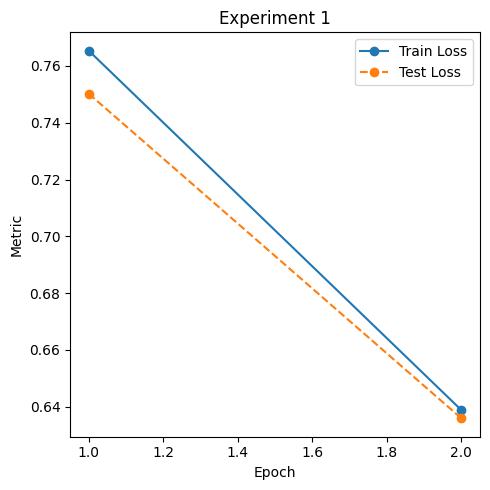

Layer (type:depth-idx)                   Output Shape              Param #
FlexibleNetwork                          [1, 2]                    --
├─Sequential: 1-1                        [1, 32, 13, 13]           4,704
│    └─Conv2d: 2-1                       [1, 16, 111, 111]         448
│    └─BatchNorm2d: 2-2                  [1, 16, 111, 111]         32
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-3                         [1, 16, 111, 111]         --
├─Sequential: 1-5                        --                        (recursive)
│    └─MaxPool2d: 2-4                    [1, 16, 55, 55]           --
│    └─Conv2d: 2-5                       [1, 32, 27, 27]           4,640
│    └─BatchNorm2d: 2-6                  [1, 32, 27, 27]           64
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-7                         [1, 32, 27, 27]           --
├─Sequential: 1-5                        --        

In [55]:
configs1 = [
    {**default_config, "conv_layers": [16, 32], "fc_layers": [32], "dropout_rate": 0.0, "label": "Experiment 1", "n_epochs": 2},
]
results1 = result_handler(configs1)
plot_handler(results1, configs1)

# Save the model
torch.save(results1["Experiment 1"]["model"].state_dict(), "model.pth")


# do a test pass through of an example input size 
summary(results1["Experiment 1"]["model"], input_size=[1, 3, image_size, image_size]) 

In [56]:
configs2 = [
    {**default_config, "conv_layers": [16, 32, 64], "fc_layers": [32], "dropout_rate": 0.0, "label": "Experiment 2"},
    {**default_config, "conv_layers": [16, 32, 64, 128], "fc_layers": [32], "dropout_rate": 0.0, "label": "Experiment 3"},
    {**default_config, "conv_layers": [16, 32, 64, 128, 256], "fc_layers": [32], "dropout_rate": 0.0, "label": "Experiment 4"},
]
results2 = result_handler(configs2)
plot_handler(results2, configs2)


Experiment: Experiment 2
Epoch 1/8 | Train Loss: 0.6758 (acc. 57.20%) | Test Loss: 0.6989 (acc. 52.50%) | Time: 62.24s
Epoch 2/8 | Train Loss: 0.6418 (acc. 63.85%) | Test Loss: 0.6041 (acc. 67.00%) | Time: 61.83s
Epoch 3/8 | Train Loss: 0.6063 (acc. 66.25%) | Test Loss: 0.6208 (acc. 63.83%) | Time: 61.79s
Epoch 4/8 | Train Loss: 0.5637 (acc. 70.95%) | Test Loss: 0.6232 (acc. 65.33%) | Time: 61.86s
Epoch 5/8 | Train Loss: 0.5512 (acc. 71.40%) | Test Loss: 0.6157 (acc. 65.00%) | Time: 62.39s
Epoch 6/8 | Train Loss: 0.5270 (acc. 72.80%) | Test Loss: 0.6139 (acc. 66.50%) | Time: 62.44s
Epoch 7/8 | Train Loss: 0.5550 (acc. 70.55%) | Test Loss: 0.5724 (acc. 69.50%) | Time: 62.14s
Epoch 8/8 | Train Loss: 0.4937 (acc. 76.10%) | Test Loss: 0.5504 (acc. 71.67%) | Time: 62.06s
Training Time: 496.75s


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 128, 1, 1])

In [ ]:
configs3 = [
    # Experiment with shallow network, low dropout
    {**default_config, "conv_layers": [16, 32], "fc_layers": [64], "dropout_rate": 0.1, "learning_rate": 0.001, "label": "Experiment 5"},
    
    # Deeper network with intermediate dropout
    {**default_config, "conv_layers": [32, 64, 128], "fc_layers": [64, 32], "dropout_rate": 0.3, "learning_rate": 0.001, "label": "Experiment 6"},
    
    # Wide layers with high dropout for regularization
    {**default_config, "conv_layers": [64, 128, 256], "fc_layers": [128, 64], "dropout_rate": 0.5, "learning_rate": 0.001, "label": "Experiment 7"},
    
    # High learning rate with a shallow network to speed convergence
    {**default_config, "conv_layers": [32, 64], "fc_layers": [64], "dropout_rate": 0.1, "learning_rate": 0.01, "label": "Experiment 8"},
    
    # Low learning rate with deep network
    {**default_config, "conv_layers": [32, 64, 128, 256], "fc_layers": [128, 64], "dropout_rate": 0.3, "learning_rate": 0.0005, "label": "Experiment 9"},
    
    # Combination of increasing depth and varied dropout
    {**default_config, "conv_layers": [16, 32, 64, 128, 256], "fc_layers": [64], "dropout_rate": 0.2, "learning_rate": 0.001, "label": "Experiment 10"},
    
    # Wide, deep network with intermediate dropout
    {**default_config, "conv_layers": [64, 128, 256, 512], "fc_layers": [256, 64], "dropout_rate": 0.3, "learning_rate": 0.001, "label": "Experiment 11"},
    
    # Moderate depth with lower dropout and standard learning rate
    {**default_config, "conv_layers": [32, 64, 128], "fc_layers": [64, 32], "dropout_rate": 0.2, "learning_rate": 0.001, "label": "Experiment 12"},
]

results3 = result_handler(configs3)
plot_handler(results3, configs3)
